In [1]:
import re
import os
import pathlib
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results").resolve()

# Directory for tidied data (output directory)
data_dir = (pathlib.Path(project_dir) / "data").resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()



# Experiment constants
exp_name = "01_http_max_throughput"
file_prefix = "exp-01"

In [2]:
"""Load and prepare the dataset

resource_df -> CPU/Mem utilization for experiments
fortio_df -> Load test results from fortio
"""

# df = pd.read_feather(data_dir / "resource_results.feather")
df = pd.read_feather(data_dir / "fortio_results.feather")

df = df[df["experiment"] == exp_name]
df = df.drop("actual_qps", 1)
df = df.explode("latency")
df = df.reset_index(drop=True)
df = df.astype({
    "experiment": "category",
    "mesh": "category",
    "requested_qps": "category",
    "payload": "category",
    "protocol": "category",
    "latency": np.float64,
})

df = df.sort_values("mesh", ascending=True)

df.head()

,experiment,mesh,requested_qps,protocol,payload,latency
39588490,01_http_max_throughput,Baseline,MAX,http,0,1.260004
41873570,01_http_max_throughput,Baseline,MAX,http,0,1.494196
41873569,01_http_max_throughput,Baseline,MAX,http,0,1.552722
41873568,01_http_max_throughput,Baseline,MAX,http,0,1.545147
41873567,01_http_max_throughput,Baseline,MAX,http,0,1.533766


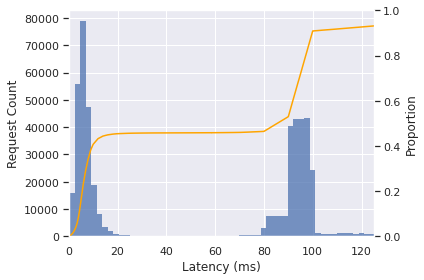

In [3]:
"""
PLOT: Histplot of Traefik mesh
Desc: Shows bimodal nature of traefik mesh latencies
"""

file_name = f"{file_prefix}-latency-distribution-traefik.pdf"


data = df[df["mesh"] == "Traefik"]

fig, ax = plt.subplots()
sns.histplot(data=data, x="latency", ec="none", ax=ax)

ax.set_ylabel("Request Count")
ax.set_xlabel("Latency (ms)")


# Y AXIS
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


# X AXIS
ax.set_xlim(0, 125)
# ax.set_xscale("log")
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


# Second plot with cumulative density
ax2 = ax.twinx()
ax2.set_alpha(0.5)
ax2.grid(False)
sns.ecdfplot(data=data, palette=["orange"], ax=ax2)
ax2.get_legend().remove()

fig.tight_layout()
fig.savefig(plot_dir / file_name)

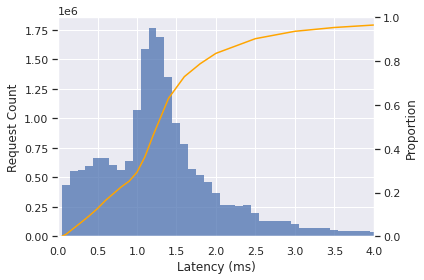

In [4]:
"""
PLOT: Histplot of baseline
Desc: Shows normal distribution of latencies
"""

file_name = f"{file_prefix}-latency-distribution-baseline.pdf"

data = df[df["mesh"] == "Baseline"]

fig, ax = plt.subplots()
sns.histplot(data=data, x="latency", binwidth=.1, ec="none", ax=ax)

ax.set_ylabel("Request Count")
ax.set_xlabel("Latency (ms)")
# ax.set_title("Histogram of latencies for Baseline")


# Y AXIS
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


# X AXIS
ax.set_xlim(0, 4)
# ax.set_xscale("log")
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


# Second plot with cumulative density
ax2 = ax.twinx()
ax2.set_alpha(0.5)
ax2.grid(False)
sns.ecdfplot(data=data, palette=["orange"], ax=ax2)
ax2.get_legend().remove()

fig.tight_layout()
fig.savefig(plot_dir / file_name)

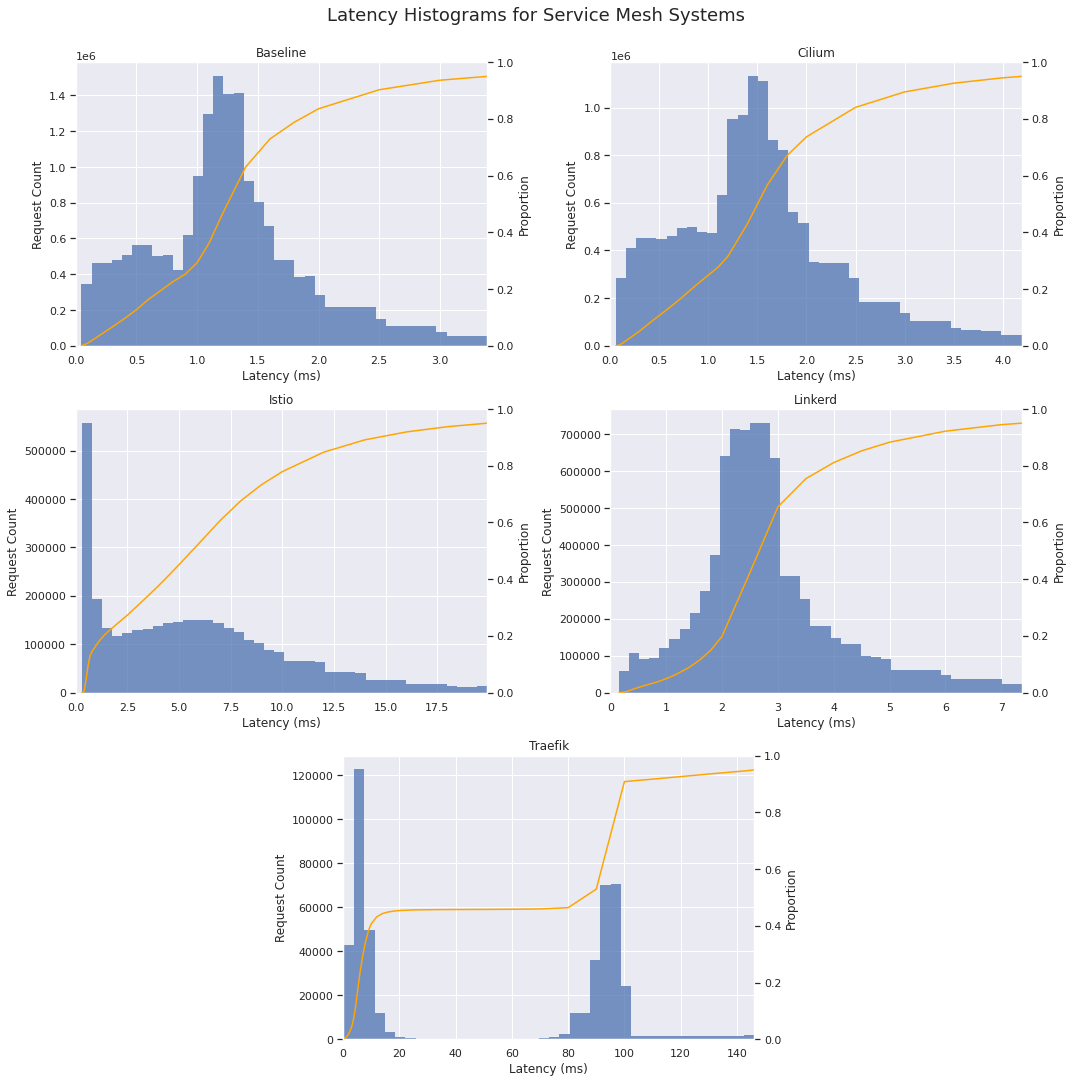

In [5]:
"""
PLOT: Histogram plots
Desc: All historams
"""

file_name = f"{file_prefix}-distributions-all.pdf"

# Create grid of plots
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=3, ncols=4)

# Create subplots, each plot is 2 cols wide
axes=[
    # Row 0
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    # Row 1 
    fig.add_subplot(gs[1, 0:2]),
    fig.add_subplot(gs[1, 2:4]),
    # Row 2 (offset by 1)
    fig.add_subplot(gs[2, 1:3]),
]

# Set figure title
fig.suptitle("Latency Histograms for Service Mesh Systems", fontsize=18, y=1)

mesh_configs = df["mesh"].unique()

for i, m in enumerate(mesh_configs):
    data = df[df["mesh"] == m]
    # filtered = data[data["latency"] < data["latency"].quantile(.95)]

    quant = data["latency"].quantile(.95)
    min = data["latency"].min()
    bins = 40
    binwidth = (quant - min) / bins

    ax = axes[i]

    sns.histplot(data=data, x="latency", binwidth=binwidth, ec="none", ax=ax)

    # Labels
    # plot_title = (
    #     f"$\\bf{row['mesh'].capitalize()}$\n"
    #     f"RPS: {row['ActualQPS']:.0f}\n"
    #     f"min: {row['Min']:.2f} ms, avg: {row['Avg']:.2f} ms, max: {row['Max']:.2f} ms"
    # )
    ax.set_ylabel("Request Count")
    ax.set_xlabel("Latency (ms)")
    ax.set_title(m)


    # Y AXIS
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


    # X AXIS
    ax.set_xlim(0, quant)
    # ax.set_xscale("log")
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


    # Second plot with cumulative density
    ax2 = ax.twinx()
    ax2.set_alpha(0.5)
    ax2.grid(False)
    sns.ecdfplot(data=data, palette=["orange"], ax=ax2)
    ax2.get_legend().remove()


fig.tight_layout()
fig.savefig(plot_dir / file_name)